Height is 4046, and width is 9216


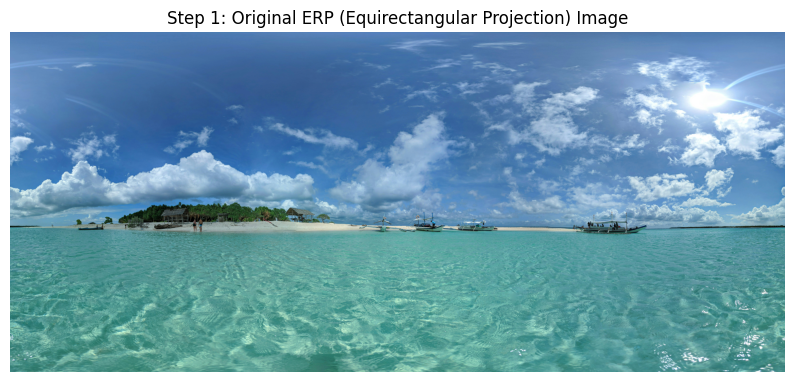

Step 2: Created 36x36 matrix for spherical tiles.


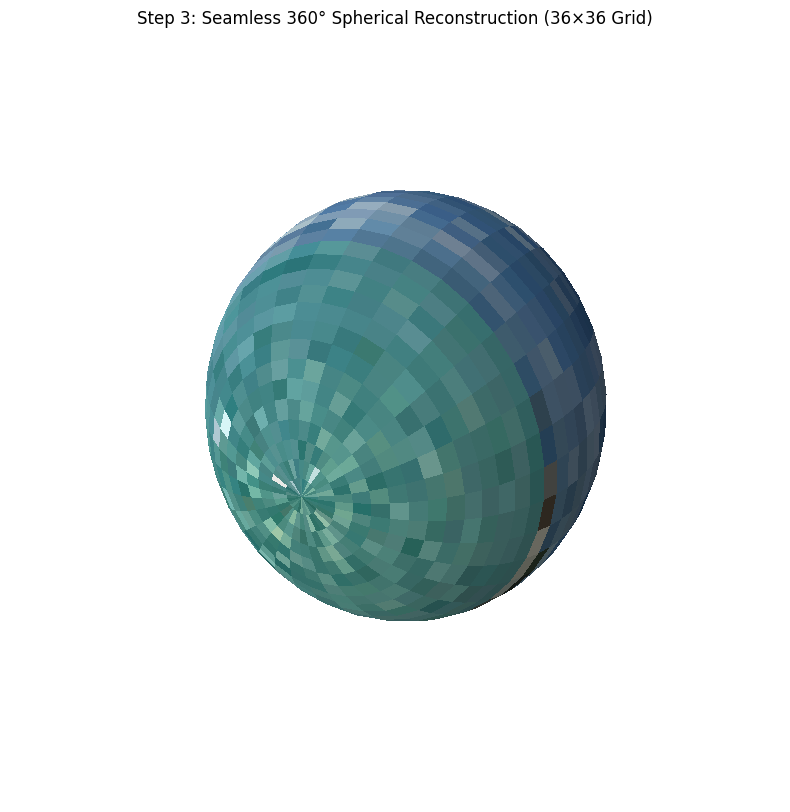

Step 4: Image successfully divided into 36×36 spherical tiles.


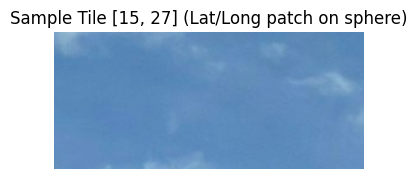

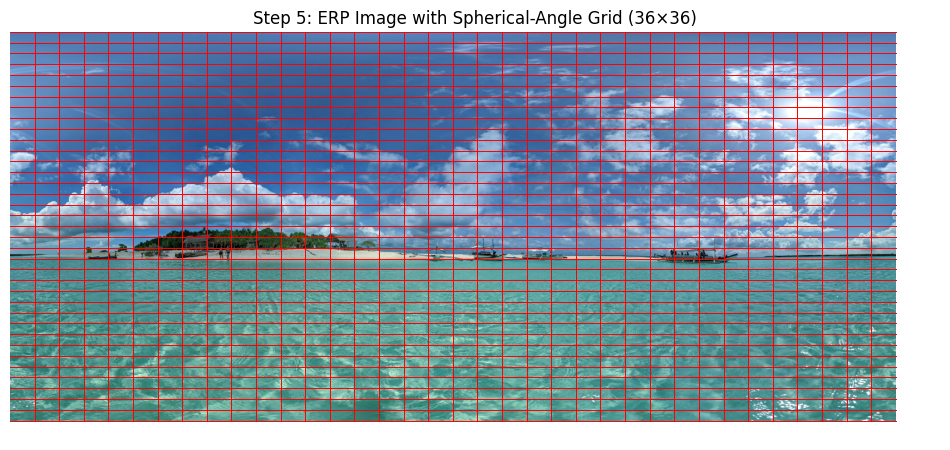

Tile 0: pixel height = 112
Tile 1: pixel height = 112
Tile 2: pixel height = 113
Tile 3: pixel height = 112
Tile 4: pixel height = 112
Tile 5: pixel height = 113
Tile 6: pixel height = 112
Tile 7: pixel height = 113
Tile 8: pixel height = 112
Tile 9: pixel height = 112
Tile 10: pixel height = 113
Tile 11: pixel height = 112
Tile 12: pixel height = 113
Tile 13: pixel height = 112
Tile 14: pixel height = 112
Tile 15: pixel height = 113
Tile 16: pixel height = 112
Tile 17: pixel height = 113
Tile 18: pixel height = 112
Tile 19: pixel height = 112
Tile 20: pixel height = 113
Tile 21: pixel height = 112
Tile 22: pixel height = 112
Tile 23: pixel height = 113
Tile 24: pixel height = 112
Tile 25: pixel height = 113
Tile 26: pixel height = 112
Tile 27: pixel height = 112
Tile 28: pixel height = 113
Tile 29: pixel height = 112
Tile 30: pixel height = 113
Tile 31: pixel height = 112
Tile 32: pixel height = 112
Tile 33: pixel height = 113
Tile 34: pixel height = 112
Tile 35: pixel height = 113


In [1]:
# ======================================
# 360° ERP Image → Spherical Projection Pipeline
# Steps 1–5
# ======================================

# STEP 1: Add and display image

# from google.colab import files

from IPython.display import Image as ColabImage
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Upload ERP image (e.g., Ocean360Picture.jpg)

# uploaded = files.upload()
# filename = list(uploaded.keys())[0]
# ColabImage(filename)

filename = "Ocean360Picture.jpg"

# Read image in RGB format
erp = cv2.imread(filename)
erp = cv2.cvtColor(erp, cv2.COLOR_BGR2RGB)
H, W, _ = erp.shape

print(f"Height is {H}, and width is {W}")

plt.figure(figsize=(10,5))
plt.imshow(erp)
plt.title("Step 1: Original ERP (Equirectangular Projection) Image")
plt.axis("off")
plt.show()

# ======================================
# STEP 2: Create 36x36 Matrix Placeholder
# ======================================
num_tiles = 36
tile_matrix = [[None for _ in range(num_tiles)] for _ in range(num_tiles)]
print(f"Step 2: Created {num_tiles}x{num_tiles} matrix for spherical tiles.")

# ======================================
# STEP 3: Reconstruct Image as Sphere
# ======================================
# Create meshgrid of longitude (λ) and latitude (φ)
u = np.linspace(0, W - 1, num_tiles)
v = np.linspace(0, H - 1, num_tiles)
U, V = np.meshgrid(u, v)

# Convert ERP pixel coords → spherical angles
lam = 2 * np.pi * (U / W - 0.5)       # longitude [-π, π]
phi = np.pi * (0.5 - V / H)           # latitude [π/2, -π/2]

# Convert spherical → Cartesian coords (X,Y,Z)
X = np.cos(phi) * np.cos(lam)
Y = np.sin(phi)
Z = np.cos(phi) * np.sin(lam)

# Sample colors from ERP for each spherical coordinate
U_int = np.clip(U.astype(int), 0, W - 1)
V_int = np.clip(V.astype(int), 0, H - 1)
colors = erp[V_int, U_int, :] / 255.0  # normalize to [0,1] for matplotlib

# Plot 3D sphere
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, facecolors=colors, rstride=1, cstride=1, linewidth=0, antialiased=False)
ax.set_box_aspect([1,1,1])
ax.set_title("Step 3: Seamless 360° Spherical Reconstruction (36×36 Grid)")
ax.axis("off")
plt.show()

# ======================================
# STEP 4: Split ERP into Spherical Tiles
# ======================================
delta_lambda = 2 * np.pi / num_tiles   # longitude step
delta_phi = np.pi / num_tiles          # latitude step

for j in range(num_tiles):
    for i in range(num_tiles):
        # Tile angular bounds
        lam_min = -np.pi + i * delta_lambda
        lam_max = -np.pi + (i + 1) * delta_lambda
        phi_max =  np.pi/2 - j * delta_phi
        phi_min =  np.pi/2 - (j + 1) * delta_phi

        # Convert angular bounds → ERP pixel coordinates
        u_min = int(((lam_min + np.pi) / (2 * np.pi)) * W)
        u_max = int(((lam_max + np.pi) / (2 * np.pi)) * W)
        v_min = int(((np.pi/2 - phi_max) / np.pi) * H)
        v_max = int(((np.pi/2 - phi_min) / np.pi) * H)

        # Clip to valid image range
        u_min, u_max = np.clip([u_min, u_max], 0, W)
        v_min, v_max = np.clip([v_min, v_max], 0, H)

        # Extract tile region from ERP
        tile_matrix[j][i] = erp[v_min:v_max, u_min:u_max, :]

print("Step 4: Image successfully divided into 36×36 spherical tiles.")

# Quick check: display one random tile
test_i, test_j = np.random.randint(0, num_tiles, 2)
tile = tile_matrix[test_j][test_i]
plt.figure(figsize=(4,4))
plt.imshow(tile)
plt.title(f"Sample Tile [{test_j}, {test_i}] (Lat/Long patch on sphere)")
plt.axis("off")
plt.show()

# ======================================
# STEP 5: ERP Image with Non-Distorted Grid Lines (Equal Spherical Angles)
# ======================================

fig, ax = plt.subplots(figsize=(12,6))
ax.imshow(erp)
ax.set_title("Step 5: ERP Image with Spherical-Angle Grid (36×36)")
ax.axis("off")

# Define tile counts
num_tiles = 36

# Draw vertical lines (longitude) — evenly spaced in λ
for i in range(1, num_tiles):
    x = i * (W / num_tiles)
    ax.plot([x, x], [0, H], color='red', linewidth=0.7)

# Draw horizontal lines (latitude) — spaced by equal φ angles
phi_vals = np.linspace(np.pi/2, -np.pi/2, num_tiles + 1)  # 36 equal latitude divisions
y_positions = H * (0.5 - (phi_vals / np.pi))  # convert φ → ERP pixel coordinate

for y in y_positions:
    ax.plot([0, W], [y, y], color='red', linewidth=0.7)

plt.show()

for j in range(num_tiles):
    y_min = int(y_positions[j])
    y_max = int(y_positions[j+1])
    pixel_height = y_max - y_min
    print(f"Tile {j}: pixel height = {pixel_height}")

